In [1]:
import pandas as pd
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from collections import Counter
from utils import visualize_images, verify_image_sizes, plot_bar
from vae import VAE, train_vae

In [2]:
basic_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3) ])
dataset = datasets.ImageFolder("data/trafic_32", transform=basic_transforms)

In [3]:
analysis_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=14)
classes = dataset.classes
print("Class count:",len(classes))

Class count: 43


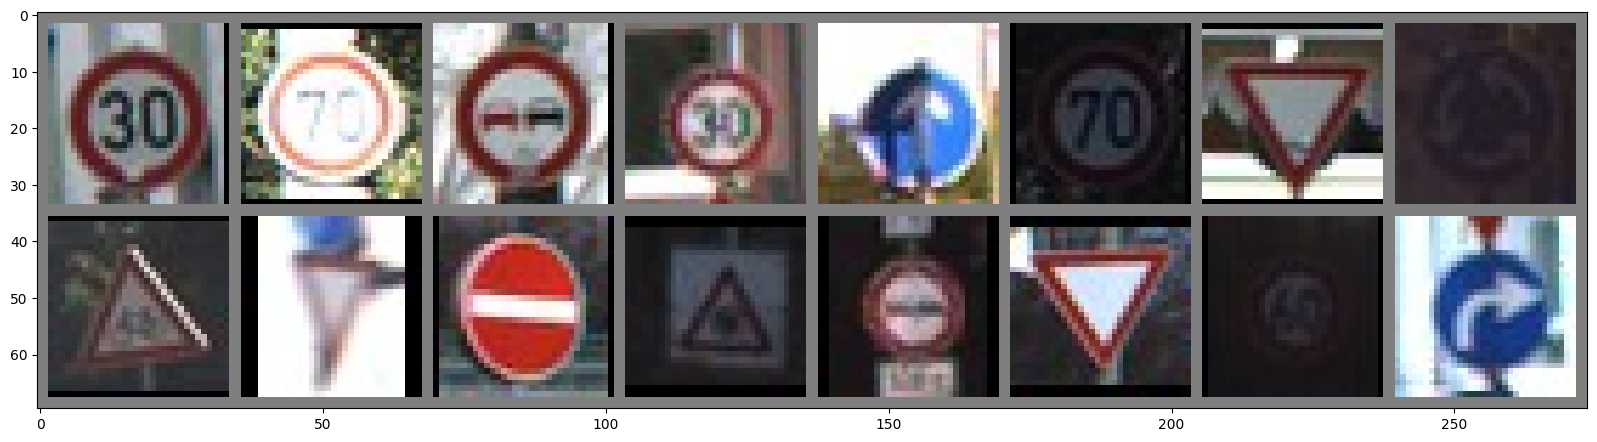

00001 00004 00009 00001 00035 00004 00013 00040 00029 00013 00017 00030 00009 00013 00003 00033


In [4]:
visualize_images(analysis_loader, classes, figsize=(20, 10))

In [5]:
verify_image_sizes(analysis_loader)

{torch.Size([3, 32, 32]): 39209}

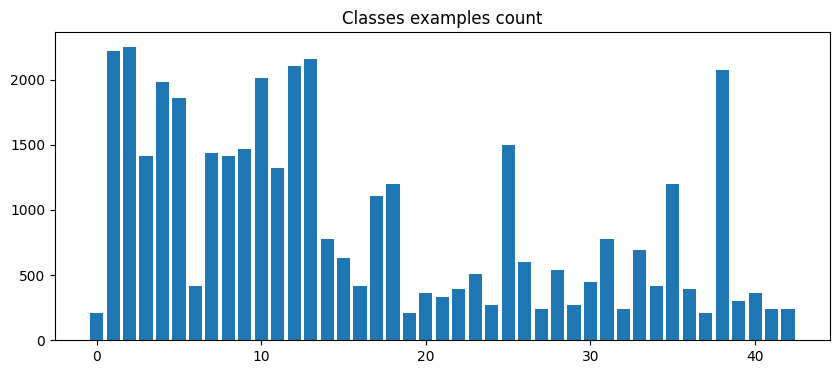

In [6]:
class_examples_num = dict(Counter(dataset.targets))
plot_bar(class_examples_num, "Classes examples count",  size=(10, 4))

In [7]:
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=14, pin_memory=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
vae = VAE(input_dim=3, hidden_dims=[32, 64, 128, 2048, 512], latent_dim=128, num_classes=43, label_emb_dim=32, device=device).to(device)

In [9]:
train_vae(vae, device, train_dataloader, epochs=50, lr=1e-3)

Epoch: 1, loss: 21616.4444
Epoch: 2, loss: 12812.7712
Epoch: 3, loss: 11090.2273
Epoch: 4, loss: 10184.4552
Epoch: 5, loss: 9684.5656
Epoch: 6, loss: 9278.9792
Epoch: 7, loss: 9042.2810
Epoch: 8, loss: 8825.6226
Epoch: 9, loss: 8614.0752
Epoch: 10, loss: 8481.7634
Epoch: 11, loss: 8313.2163
Epoch: 12, loss: 8171.6429
Epoch: 13, loss: 8065.8866
Epoch: 14, loss: 7990.3291
Epoch: 15, loss: 7863.5365
Epoch: 16, loss: 7795.4995
Epoch: 17, loss: 7739.6006
Epoch: 18, loss: 7662.9313
Epoch: 19, loss: 7607.3235
Epoch: 20, loss: 7517.2884
Epoch: 21, loss: 7463.5583
Epoch: 22, loss: 7435.1141
Epoch: 23, loss: 7365.1149
Epoch: 24, loss: 7324.0056
Epoch: 25, loss: 7286.6010
Epoch: 26, loss: 7232.6717
Epoch: 27, loss: 7186.0320
Epoch: 28, loss: 7178.3622
Epoch: 29, loss: 7117.0023
Epoch: 30, loss: 7077.4326
Epoch: 31, loss: 7037.5953
Epoch: 32, loss: 7020.5417
Epoch: 33, loss: 6984.2322
Epoch: 34, loss: 6956.1797
Epoch: 35, loss: 6916.3171
Epoch: 36, loss: 6897.9550
Epoch: 37, loss: 6870.0776
Epoch:

In [18]:
print(next(iter(train_dataloader))[1].dtype)

torch.int64


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import utils


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

generated_images = vae.generate(torch.Tensor([1, 0, 3, 5, 4, 6, 7, 8, 9]).long())
imshow(utils.make_grid(generated_images ))


RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)

In [ ]:
# model = VAE(input_dim=3, hidden_dims=[32, 64, 128, 2048, 512], latent_dim=128, num_classes=43, label_emb_dim=32, device=device).to(device)
# x = torch.randn(8, 3, 32, 32, device=device)
# y = torch.randint(0, 43, (8,), device=device)
# out, mu, logvar = model(x, y)   
# loss = ((out - x)**2).mean() + 0.5*((mu**2 + logvar.exp() - 1 - logvar).sum()/x.size(0))
# loss.backward()
